In [16]:
require 'cutorch'
require 'cunn';
require 'nn';
require 'image';
require 'mnist_loader';

In [17]:
generator = nn.Sequential()
local p = nn.ParallelTable()

local noiseBranch = nn.Sequential()
noiseBranch:add(nn.Linear(100, 200))
noiseBranch:add(nn.ReLU())

local classBranch = nn.Sequential()
classBranch:add(nn.Linear(10, 1000))
classBranch:add(nn.ReLU())

p:add(noiseBranch)
p:add(classBranch)

generator:add(p)
generator:add(nn.JoinTable(1))

generator:add(nn.Linear(1200, 32*32))
generator:add(nn.Tanh())
generator:add(nn.Reshape(32, 32))


In [18]:
local labelvector = torch.zeros(10)
local num = 8
labelvector:zero()
labelvector[9] = 1
local input = {torch.randn(100), labelvector}
output = generator:forward(input)

In [19]:
-- GPU test
local labelvector = torch.zeros(10):cuda()
local num = 8
labelvector:zero()
labelvector[9] = 1
local input = {torch.randn(100):cuda(), labelvector}
output = generator:cuda():forward(input)

In [27]:
criterion = nn.ClassNLLCriterion()

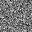

In [20]:
itorch.image(output)

In [21]:
discriminator = nn.Sequential()


local p = nn.ParallelTable()

local imgBranch = nn.Sequential()
imgBranch:add(nn.Reshape(32*32))


imgBranch:add(nn.Maxout(32*32, 240, 5))
imgBranch:add(nn.ReLU())
imgBranch:add(nn.Maxout(240, 240, 4))
imgBranch:add(nn.ReLU())

local classBranch = nn.Sequential()
classBranch:add(nn.Maxout(10, 50, 5))
classBranch:add(nn.ReLU())
classBranch:add(nn.Maxout(50, 240, 4))
classBranch:add(nn.ReLU())

p:add(imgBranch)
p:add(classBranch)

discriminator:add(p)
discriminator:add(nn.JoinTable(1))
discriminator:add(nn.Linear(480, 2))
discriminator:add(nn.LogSoftMax())

In [22]:
trainSet = mnist.loadTrainSet()

<mnist> done	


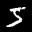

In [23]:
inputImg = trainSet[1][1]:view(32, 32)
inputVector = trainSet[1][2]
itorch.image(inputImg)

In [24]:
res = discriminator:forward({inputImg, inputVector})
print(res)

-0.6794
-0.7071
[torch.DoubleTensor of size 2]



In [26]:
res = discriminator:cuda():forward({inputImg:cuda(), inputVector:cuda()})
print(res)

-0.6794
-0.7071
[torch.CudaTensor of size 2]



In [39]:
discriminator:zeroGradParameters()
real_target = 1
criterion = criterion:cuda()

local t = criterion:backward(res, real_target)
discriminator:backward({inputImg:cuda(), inputVector:cuda()}, t)
learningRate = 0.0001
discriminator:updateParameters(learningRate)
